# <center>Tecnologias e Aplicações - TP Individual<center>

## <center>Image Colorization Autoencoder<center>

### <center>Equipa<center>
<center><img src="shaman.png" width="150"><center>
<center> <b>A75569 - João Leal<b><center>

# Introdução

&emsp;Um Autoencoder é uma de rede neuronal artificial, capaz de aprender e indentificar a representação de dados de forma não supervisionada, sendo normalmente usada para redimensionar, compactar ou extrair ruído de imagens.

&emsp;Neste âmbito e de forma a explorar a capacidade deste tipo de redes, foi desenvolvido um projeto onde se pretende usar um Autoencoder de forma a aprender a colorizar imagens, posteriormente testando-o com imagens em *grayscale* dadas como input, aquando da previsão do modelo.

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from skimage.io import imsave,imshow
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os, random
import numpy as np
from PIL import Image
import tensorflow as tf

# Dataset

&emsp;Para este projeto, foi escolhido um dataset de *Pokémon* cujo *download* pode ser efetuado a partir do seguinte link:

* https://www.kaggle.com/dollarakshay/pokemon-images

&emsp;Este dataset contem 801 imagens únicas de *Pokémons* ,sendo apresentadas em seguida alguns exemplos.

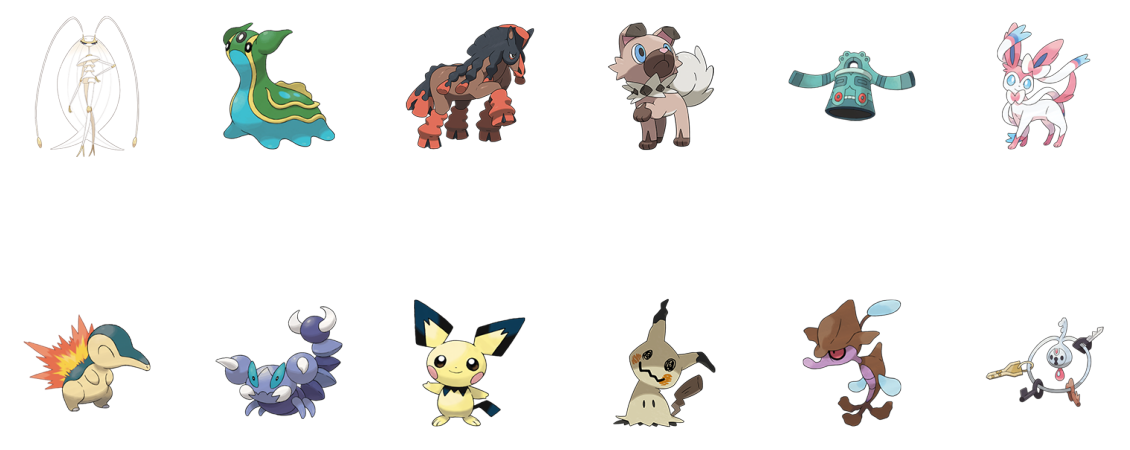

In [85]:
columns = 6
rows = 8 / columns + 1  
plt.figure(figsize=(20, 4 * rows))
for n in range(12):
    random_file = random.choice(os.listdir("dataset/POKEMON/"))    
    ax = plt.subplot(rows, columns, n+1)
    ground_truth = mpimg.imread(f'dataset/POKEMON/{random_file}')
    plt.imshow(ground_truth)
    plt.axis('off')

# Load do dataset

&emsp;Aquando do load do dataset é feita uma normalização aos valores dos pixeis das imagens, de forma a obter valores no intervalo [0,1]. Além disso, é também aplicado um redimensionamento da imagem para o tamanho 128x128.

In [2]:
BATCH_SIZE = 16
data_path = 'dataset/'

#Image Normalization
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Image Loading and Resizing
train = train_datagen.flow_from_directory(data_path,
                                          target_size=(128,128),
                                          batch_size=801,
                                          class_mode=None)

Found 801 images belonging to 1 classes.


# LAB Color Space

&emsp;Normalmente, a maneira mais usada para representar imagens é através do modelo de cor **RGB**. Contudo, existem outros modelos diferentes capazes dessa representação, e uma delas é o modelo de cores **LAB**.

&emsp;Resumidamente, este modelo expressa a cor da imagem recorrendo a 3 canais distintos:

   * **L**: representa a luminosidade numa escala de **0** (preto) a **100** (branco), portanto, uma representação em *grayscale*.
   
   * **A**: representa o espectro de cores verde-vermelho, numa escala de **-128** (verde) a **127** (vermelho);
   
   * **B**: representa o espectro de cores azul-amarelo, numa escala de **-128** (azul) a **127** (amarelo);


<center><img src="lab.png" width="750"><center>

&emsp;Recorrendo à utilização deste modelo para representar as cores da nossa imagem conseguimos aumentar a performance da nossa rede uma vez que temos a imagem em *grayscale* no canal *L* e a sua complexidade de cores reduzida a apenas 2 canais *A* e *B*, quando comparado com o modelo **RGB**.
    
&emsp;Para tal, recorremos à função *rgb2lab* para a conversão entre modelos de cor. Posteriormente, guardamos em **X** o canal *L* das imagens, ou seja, as imagens *grayscale*. Em contrapartida, guardamos em **Y** os restantes canais *A* e *B*, ou seja, os diferentes níveis de cor das imagens. De notar que, como os valores destes dois últimos canais estão compreendidos no intervalo [-127,128], dividimos estes valores por 128, ficando compreendidos no intervalo [-1,1].

In [86]:
X = []
Y = []

for img in train[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0])
        Y.append(lab[:,:,1:] / 128)
    except:
        print("Error in RGB to LAB conversion")

X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape + (1,))

print(X.shape)
print(Y.shape)

(801, 128, 128, 1)
(801, 128, 128, 2)


# Autoencoder

&emsp;A arquitetura de um autoencoder consiste em 3 partes:

   * **Encoder**: Componente onde o modelo aprende como reduzir as dimensões e a compactar a informação dada como input, resultando numa representação codificada.

   * **Bottleneck**: Camada interior que contém a representação compactada dos dados de entrada.

   * **Decoder**: Componente onde o modelo aprende a reconstruir os dados a partir da representação compactada, de forma a ficar mais próximo possível do input original.

<centering><img src="autoencoder.png"><centering>
    
&emsp;Assim sendo, para o *encoder* foram adicionadas 8 camadas de convolução de forma a este ser capaz de aprender os detalhes mais importantes da imagem. Posteriormente, para o *decoder*, além de camadas de convolução são também adicionadas camadas de redimensionamento (*UpSampling2D*) de forma a recontruir a imagem no seu tamanho normal.

&emsp;Com a arquitetura definida, somos capazes então capazes de fornecer as imagens em *grayscale* e as respetivas imagens coloridas, de forma a ser possível fazer previsões dos canais *A* e *B* das imagens, ou seja, a colorir imagens. 

In [4]:
#-- ENCODER --

model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', padding='same', strides=2, input_shape=(128,128,1)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#-- DECODER --

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3,3), activation='tanh', padding='same'))
model.add(UpSampling2D((2,2)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 512)       1180160   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 512)       2

In [5]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Treino do Modelo

In [6]:
model.fit(X,Y,validation_split=0.2, epochs=100, batch_size=16)

Epoch 1/100
40/40 [==============================] - 91s 2s/step - loss: 0.0822 - accuracy: 0.3548 - val_loss: 0.0054 - val_accuracy: 0.5555
Epoch 2/100
40/40 [==============================] - 90s 2s/step - loss: 0.0054 - accuracy: 0.6471 - val_loss: 0.0053 - val_accuracy: 0.6420
Epoch 3/100
40/40 [==============================] - 90s 2s/step - loss: 0.0055 - accuracy: 0.6749 - val_loss: 0.0054 - val_accuracy: 0.7119
Epoch 4/100
40/40 [==============================] - 90s 2s/step - loss: 0.0055 - accuracy: 0.6933 - val_loss: 0.0053 - val_accuracy: 0.7044
Epoch 5/100
40/40 [==============================] - 90s 2s/step - loss: 0.0054 - accuracy: 0.6305 - val_loss: 0.0053 - val_accuracy: 0.6040
Epoch 6/100
40/40 [==============================] - 90s 2s/step - loss: 0.0054 - accuracy: 0.6253 - val_loss: 0.0054 - val_accuracy: 0.7242
Epoch 7/100
40/40 [==============================] - 90s 2s/step - loss: 0.0054 - accuracy: 0.6983 - val_loss: 0.0053 - val_accuracy: 0.6160
Epoch 8/100
4

Epoch 59/100
40/40 [==============================] - 90s 2s/step - loss: 0.0018 - accuracy: 0.7777 - val_loss: 0.0064 - val_accuracy: 0.7173
Epoch 60/100
40/40 [==============================] - 90s 2s/step - loss: 0.0018 - accuracy: 0.7773 - val_loss: 0.0062 - val_accuracy: 0.7160
Epoch 61/100
40/40 [==============================] - 91s 2s/step - loss: 0.0017 - accuracy: 0.7786 - val_loss: 0.0063 - val_accuracy: 0.7193
Epoch 62/100
40/40 [==============================] - 90s 2s/step - loss: 0.0017 - accuracy: 0.7829 - val_loss: 0.0062 - val_accuracy: 0.7211
Epoch 63/100
40/40 [==============================] - 90s 2s/step - loss: 0.0016 - accuracy: 0.7835 - val_loss: 0.0063 - val_accuracy: 0.7227
Epoch 64/100
40/40 [==============================] - 90s 2s/step - loss: 0.0016 - accuracy: 0.7865 - val_loss: 0.0063 - val_accuracy: 0.7210
Epoch 65/100
40/40 [==============================] - 90s 2s/step - loss: 0.0016 - accuracy: 0.7858 - val_loss: 0.0064 - val_accuracy: 0.7155
Epoch 

# Resultados

&emsp;Os resultados obtidos são representandos abaixo. 

&emsp;Em primeiro lugar efetuamos uma conversão para *grayscale* da imagem obtida, fornecendo-a logo de seguida para a previsão dos canais *A* e *B*. Por conseguinte, e com essa previsão feita, somos capazes de colorizar a imagem dada como input, juntando sobre esta os canais *A* e *B* previstos pelo modelo.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


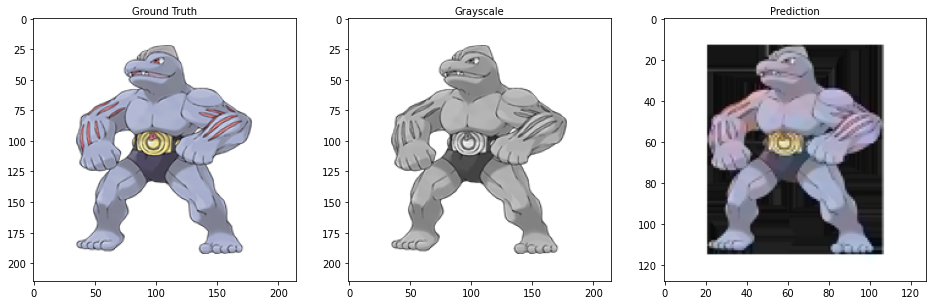

In [87]:
test_image = []

random_file = random.choice(os.listdir("dataset/POKEMON_test/"))

# Convert to grayscale
img = Image.open(f'dataset/POKEMON_test/{random_file}')
img = img.convert('LA')
img.save('greyscale.png')

gray = img_to_array(load_img('greyscale.png'))
gray = resize(gray,(128,128))

test_image.append(gray)
test_image = np.array(test_image, dtype=float)
test_image = rgb2lab(1.0/255 * test_image)[:,:,:,0]
test_image = test_image.reshape(test_image.shape + (1,))

output = model.predict(test_image)
output = output*128

result = np.zeros((128,128,3))
result[:,:,0] = test_image[0][:,:,0]
result[:,:,1:] = output[0]

#imshow(lab2rgb(result))
imsave('result.png',lab2rgb(result))

# Side-by-Side Comparison (RGB,Grayscale,Prediction)
fig,axes=plt.subplots(ncols=3,figsize=(16,16))

# Ground Truth Image plot
ground_truth = mpimg.imread(f'dataset/POKEMON_test/{random_file}')
axes[0].imshow(ground_truth)
axes[0].set(xlabel="Ground Truth")
axes[0].xaxis.set_label_position('top')

# Graysacle Image plot
gray = mpimg.imread('greyscale.png')
axes[1].imshow(gray)
axes[1].set(xlabel="Grayscale")
axes[1].xaxis.set_label_position('top')

# Prediction Image plot
prediction = mpimg.imread('result.png')
axes[2].imshow(prediction)
axes[2].set(xlabel="Prediction")
axes[2].xaxis.set_label_position('top')

plt.show()